In [1]:
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import nibabel as nb
import random
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import cv2
from scipy import ndimage
from scipy.stats import gaussian_kde

import matplotlib.patches as patches

In [2]:
"""
The new and improved linear regression. From now on, we're focusing on doing things very visually and always plotting MRI v. SoS. 
Then we can do the linear regression and see how the line lines up with the points (pun intended).
We're trying to use functions as much as posible so this isn't unnecessarily painful. 

Variables guide:
 . labels_i : lists used to create sections for "batch" i (batches usually have 5 sections, ie. len(labels_i) == 5 )
 . all_m_i : lists of whole raw (unfiltered) mri sections
 . all_s_i : lists of whole raw (unfiltered) sos sections
 . fil_m_i : lists of filtered mri sections
 . fil_s_i : lists of filtered sos sections
 . coef_i : lists of coefficients resulting from linear regression on each of the sections 
 . intercept_i : lists of intercepts resulting from linear regression on each of the sections
 . r2_i : lists of R2 values
 . median_m_i : all_m_i after median filtering
 . median_s_i : all_s_i after median filtering
 . fm_m_i : filtered median_m_i
 . fm_s_i : filtered median_s_i
"""

'\nThe new and improved linear regression. From now on, we\'re focusing on doing things very visually and always plotting MRI v. SoS. \nThen we can do the linear regression and see how the line lines up with the points (pun intended).\nWe\'re trying to use functions as much as posible so this isn\'t unnecessarily painful. \n\nVariables guide:\n . labels_i : lists used to create sections for "batch" i (batches usually have 5 sections, ie. len(labels_i) == 5 )\n . all_m_i : lists of whole raw (unfiltered) mri sections\n . all_s_i : lists of whole raw (unfiltered) sos sections\n . fil_m_i : lists of filtered mri sections\n . fil_s_i : lists of filtered sos sections\n . coef_i : lists of coefficients resulting from linear regression on each of the sections \n . intercept_i : lists of intercepts resulting from linear regression on each of the sections\n . r2_i : lists of R2 values\n . median_m_i : all_m_i after median filtering\n . median_s_i : all_s_i after median filtering\n . fm_m_i : fi

In [3]:
mri_file = glob('/Volumes/DISK_IMG/100610/m100610_T1w.nii.gz')[0]
mri_im = nb.load(mri_file)
# mri_hdr = mri_im.header
mri_data = mri_im.get_fdata()

In [4]:
sos_file = glob('/Volumes/DISK_IMG/100610/Vp.nii.gz')[0]
sos_im = nb.load(sos_file)
# sos_hdr = sos_im.header
sos_data = sos_im.get_fdata()

In [5]:
""" Plotting functions:
where_sections : plots whole mri slice and squares of where the sections are located
plot_any_number : plots raw mri slices and scatter plots
plot_any_filtered : plots raw mri slices and filtered scatter plots. 
  we need a special function for this because it needs the raw AND filtered data
plot_line : plot the raw mri and the filtered test scatter plot with the line obtained
  from linear regression on top

"""
def where_sections(slice, labels):
    """ 
    Inputs:
      slice : a slice of the mri 
      labels : list of a length equal to the number of sections we're doing
        each member of the list is a comma-separated string, where each element:
        labels[0] = slice number
        labels[1] = start y value
        labels[2] = end y value
        labels[3] = start x value
        labels[4] = end x value
        ie. "slice_n, y_start, y_end, x_start, x_end"

    Outputs:
      nothing

    Function:
      plots the mri with rectangles where the setcions will be on top.
    """

    
    colors = []
    colors.append('w')
    colors.append('r')
    colors.append('y')
    colors.append('k')
    colors.append('m')

    fig, ax = plt.subplots()
    plt.imshow(slice)
    for i in range(len(labels)):
        [_,y0,y1,x0,x1] = labels[i].split(',')
        r = patches.Rectangle((int(x0), int(y0)), int(x1)-int(x0), int(y1)-int(y0), linewidth=1, edgecolor=colors[i], facecolor='None')
        ax.add_patch(r)
    plt.show()

def plot_any_number(all_m, all_s, labels):
    """
    Inputs:
      all_m : list of mri sections, each section is an array
      all_s : list of sos sections, each is an array

    Outputs:
      nothing

    Functions: 
      plots the mri in one row and its corresponding scatter plot in the row below
    
    """
    length = len(all_m)
    
    plt.subplots(2,length,figsize=(100/length, 8))
    for i in range(length):
        [slice,y0,y1,x0,x1] = labels[i].split(',')
        plt.subplot(2,length,i+1)
        plt.title("slice "+slice+" ["+y0+":"+y1+","+x0+":"+x1+"]")
        plt.imshow(all_m[i])

        plt.subplot(2,length,length+i+1)
        plt.scatter(all_m[i], all_s[i][:],s=2)

def plot_any_filtered(all_m, fil_m, fil_s, labels):
    """ 
    Inputs:
      all_m : list of mri sections
      all_s : list of sos sections
      fil_m : list of filtered mri sections
      fil_s : list of filtered sos sections
      labels : list of a length equal to the number of sections we're doing
        each member of the list is a comma-separated string, where each element:
        labels[0] = slice number
        labels[1] = start y value
        labels[2] = end y value
        labels[3] = start x value
        labels[4] = end x value
        ie. "slice_n, y_start, y_end, x_start, x_end"

      Outputs:
        nothing

      Function: 
        plots the raw mris in one row and the filtered scatter plots below  
    """
    length = len(all_m)
    plt.subplots(2,length,figsize=(20,8))
    for i in range(length):
        [slice,y0,y1,x0,x1] = labels[i].split(',')

        # this is to make it into a density scatter plot
        xy = np.vstack([fil_m[i],fil_s[i]])
        z = gaussian_kde(xy)(xy)    

        plt.subplot(2,length,i+1)
        plt.title("slice "+slice+" ["+y0+":"+y1+","+x0+":"+x1+"]")
        plt.imshow(all_m[i])

        plt.subplot(2,length,length+i+1)
        plt.scatter(fil_m[i], fil_s[i],c=z,s=2)

def plot_line(all_m, fil_m, fil_s, coef, intercept, r2, labels):
  """ 
  Inputs:
    all_m : list of mri sections
    fil_m : list of filtered mri sections
    fil_s : list of filteres sos sections
    coef : list of coefficients from linear regression of each of the sections
    intercept : list of intercepts from linear reg of each of the sections
    data : list of [test_X, test_y] used for linear reg for each section
    labels: as above.

  Outputs:
    nothing

  Function:
    plots mri images in one row and the scatter plot of the filtered data with the line
    from linear regression on top in the row below
  """
  length = len(all_m)
  plt.subplots(2,length,figsize=(20,8))
  for i in range(length):
    # t_fil_m = np.array(fil_m[i]).flatten()
    # t_fil_s = np.array(fil_s[i]).flatten()

    [slice,y0,y1,x0,x1] = labels[i].split(',')

    plt.subplot(2,length,i+1)
    plt.imshow(all_m[i])
    plt.title("slice "+slice+" ["+y0+":"+y1+","+x0+":"+x1+"]")

    # this is to make it into a density scatter plot
    xy = np.vstack([fil_m[i],fil_s[i]])
    z = gaussian_kde(xy)(xy)    

    plt.subplot(2,5,length+i+1)
    # plt.scatter(data[i][0],data[i][1],s=5)
    plt.scatter(fil_m[i], fil_s[i], c=z, s=2)
    x = np.linspace(min(fil_m[i]),max(fil_m[i]), num=1000)
    y = (coef[i] * x) + intercept[i]
    plt.plot(x, y[0,:], '-r')
    # plt.xlim(int(min(fil_m_3[i])-10),int(max(fil_m_3[i])+10))
    plt.title("R2 = " + str(r2[i])[1:7])

In [6]:
def create_sections(mri_im, sos_im, labels):
    """
    Inputs:
      mri_im : whole mri 
      sos_im : whole sos
      labels: list of a length equal to the number of sections we're doing
        each member of the list is a comma-separated string, where each element:
        labels[0] = slice number
        labels[1] = start y value
        labels[2] = end y value
        labels[3] = start x value
        labels[4] = end x value
        ie. "slice_n, y_start, y_end, x_start, x_end"

    Output:
      m : list of flat sections of mri 
      s : list of flat sections of sos
    """


    m = []
    s = []
    for i in range(len(labels)):
        [slice,y0,y1,x0,x1] = labels[i].split(',')
        m.append(np.array(mri_im[:,:,int(slice)][int(y0):int(y1),int(x0):int(x1)]))
        s.append(np.array(sos_im[:,:,int(slice)][int(y0):int(y1),int(x0):int(x1)]))

    return m, s

def filter_one(m, s, T):
    fil_m = []
    fil_s = []
    temp_m = np.array(m).flatten()
    temp_s = np.array(s).flatten()
    for x in range(temp_s.shape[0]):
        if(not np.isnan(T[0])) and (np.isnan(T[1])): #only filtering downwards
            # print("filtering downwards")
            if(temp_s[x] > T[0]):
                fil_m.append(temp_m[x])
                fil_s.append(temp_s[x])

        if( np.isnan(T[0]) ) and (not np.isnan(T[1])): #only filtering upwards
            # print("filtering upwards")
            if(temp_s[x] < T[1]):
                fil_m.append(temp_m[x])
                fil_s.append(temp_s[x])
            # else: print(temp_s[x])
        
        if(not np.isnan(T[0])) and (not np.isnan(T[1])): #filtering in both directions
            # print("filtering both")
            if(temp_s[x] > T[0]) and (temp_s[x] < T[1]):
                fil_m.append(temp_m[x])
                fil_s.append(temp_s[x])
    return fil_m, fil_s

def filter_all(all_m, all_s, Ts):
    """
    Inputs: 
    all_m : list of mri sections
    all_s : list of sos sections
    Ts : 
      Ts[0] : low threshold (minimum sos value)
      Ts[1] : high threshold (maximum sos value)

    Outputs:
    fil_m : all_m without the points that correspond to sos above the maximum and below the minimum
    fil_s : all_s without the points above the max and below the min
    """
    fil_m = [[] for x in range(len(all_m))]
    fil_s = [[] for x in range(len(all_s))]
    for i in range(len(all_m)):
        temp_m = all_m[i].flatten()
        temp_s = all_s[i].flatten()
        for x in range(temp_s.shape[0]):
            if(not np.isnan(Ts[i][0])) and (np.isnan(Ts[i][1])): #only filtering downwards
                # print("filtering downwards")
                if(temp_s[x] > Ts[i][0]):
                    fil_m[i].append(temp_m[x])
                    fil_s[i].append(temp_s[x])

            if( np.isnan(Ts[i][0]) ) and (not np.isnan(Ts[i][1])): #only filtering upwards
                # print("filtering upwards")
                if(temp_s[x] < Ts[i][1]):
                    fil_m[i].append(temp_m[x])
                    fil_s[i].append(temp_s[x])
                # else: print(temp_s[x])
            
            if(not np.isnan(Ts[i][0])) and (not np.isnan(Ts[i][1])): #filtering in both directions
                # print("filtering both")
                if(temp_s[x] > Ts[i][0]) and (temp_s[x] < Ts[i][1]):
                    fil_m[i].append(temp_m[x])
                    fil_s[i].append(temp_s[x])

    return fil_m, fil_s

In [7]:
# these two are used for linear regression
def analyse_one_slice(mri_slice, sos_slice):
  """
  Inputs:
    mri_slice : mri section to do linear reg on
    sos_slice : sos section to do linear reg on

  Outputs:
    coef : coefficient of line 
    intercept : y-intercept of line
    r2 : r2 of fit
    test_X
    test_y

  Divides data into train and test, fits a linear reg model on train data and predicts test SoS points from test_X
  """
  # start: train-test split (70% train, 30% test)
  mri_slice = pd.Series(mri_slice).fillna(0)
  sos_slice = pd.Series(sos_slice).fillna(0)
  
  train_X = pd.DataFrame()
  train_y = pd.DataFrame()
  train_indices = []
  for i in range(int(0.7*mri_slice.shape[0])):
      # get 70% of the set for training from the whole thing randomly
      r = random.randint(0, mri_slice.shape[0]-1) 
      train_indices.append(r)
      train_X = train_X.append(pd.Series(mri_slice.iloc[r]), ignore_index=True)
      train_y = train_y.append(pd.Series(sos_slice.iloc[r]), ignore_index=True)

  test_X = pd.DataFrame()
  test_y = pd.DataFrame()
  test_indices = []
  while test_y.shape[0] < 0.30*mri_slice.shape[0]:
      r = random.randint(0, mri_slice.shape[0]-1)
      if(r not in train_indices): 
          test_indices.append(r)
          test_X = test_X.append(pd.Series(mri_slice.iloc[r]), ignore_index=True)
          test_y = test_y.append(pd.Series(sos_slice.iloc[r]), ignore_index=True)

  train_X = np.array(train_X).reshape(-1,1) # this is necessary for the linear regression
  train_y = np.array(train_y).reshape(-1,1)
  test_X = np.array(test_X).reshape(-1,1)
  test_y = np.array(test_y).reshape(-1,1)
  # end: train-test split

  # train_X, test_X, train_y, test_y = train_test_split(pd.Series(mri_slice).fillna(0), pd.Series(sos_slice).fillna(0), test_size=0.33, random_state=42)

  # linear regression training & prediction
  linear = LinearRegression()
  linear.fit(train_X, train_y)
  preds = linear.predict(test_X)
  coef = linear.coef_
  intercept = linear.intercept_
  r2 = linear.score(test_y, preds)

  return coef, intercept, r2, [test_X, test_y]

def analyse_all(all_m,all_s):
  """ 
  Inputs:
    all_m : list of all mri sections
    all_s : list of all sos sections

  Outputs:
    coef : list of all coefficients resulting from doing linear reg on each slice
    intercept : list of all intercepts resulting from doing linear reg on each slice
    r2 : list of all r2 
    data : list of all [test_X, test_y]
  """
  coef = []
  intercept = []
  r2 = []
  data = []
  for i in range(len(all_m)):
    t_coef, t_intercept, t_r2, t_data = analyse_one_slice(all_m[i], all_s[i])
    coef.append(t_coef)
    intercept.append(t_intercept)
    r2.append(t_r2)
    data.append(t_data)

  return coef, intercept, r2, data

In [8]:
def filter_df(df, T):
    f_df = df.copy()
    for x in range(df.shape[0]):
        if(not np.isnan(T[0])) and (np.isnan(T[1])): #only filtering downwards
            # print("filtering downwards")
            if(df['SOS'][x] < T[0]):
                f_df = f_df.drop(x)

        if( np.isnan(T[0]) ) and (not np.isnan(T[1])): #only filtering upwards
            # print("filtering upwards")
            if(df['SOS'][x] > T[1]):
                f_df = f_df.drop(x)
            # else: print(temp_s[x])
        
        if(not np.isnan(T[0])) and (not np.isnan(T[1])): #filtering in both directions
            # print("filtering both")
            if(df['SOS'][x] < T[0]):
                f_df = f_df.drop(x)
            if(df['SOS'][x] > T[1]):
                f_df = f_df.drop(x)
    return f_df

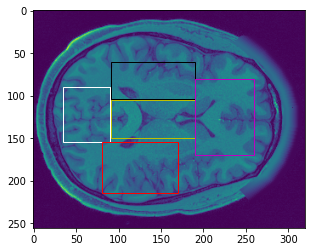

In [36]:
labels = [] # structure is slice, y_start, y_end, x_start, x_end,
labels.append("160,90,154,35,90") #plotted in white
labels.append("160,155,215,80,170") #plotted in red
labels.append("160,105,150,91,190") #plotten in yellow
labels.append("160,60,104,91,190") #plotted in black
labels.append("160,80,170,190,260") #plotted in magenta

where_sections(mri_data[:,:,160],labels)
all_m, all_s = create_sections(mri_data, sos_data, labels)
# creating the thresholds we'll use to filter
Ts = []
Ts.append([1540, 1599])
Ts.append([1540, 1800])
Ts.append([1540, np.nan])
Ts.append([1540, np.nan])
Ts.append([1540, np.nan])

# plot_any_number(all_m, all_s, labels)

fil_m, fil_s = filter_all(all_m, all_s, Ts) # actually filter data
# plot_any_filtered(all_m, fil_m, fil_s,)
coef, intercept, r2, data = analyse_all(fil_m, fil_s) # perform linear regression

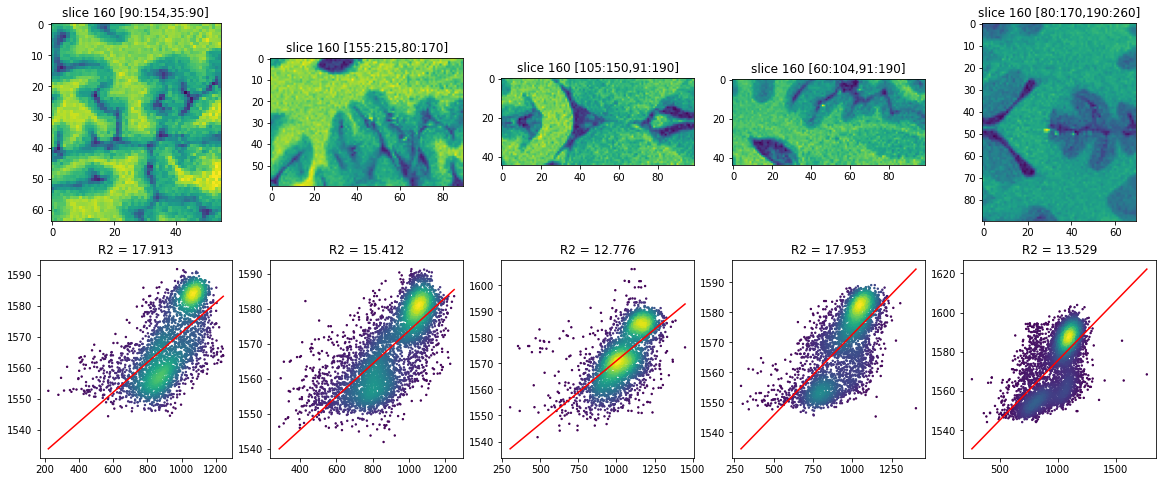

In [10]:
plot_line(all_m, fil_m, fil_s, coef, intercept, r2, labels)

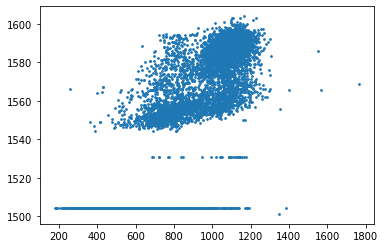

In [11]:
plt.scatter(all_m[4],all_s[4],s=3)

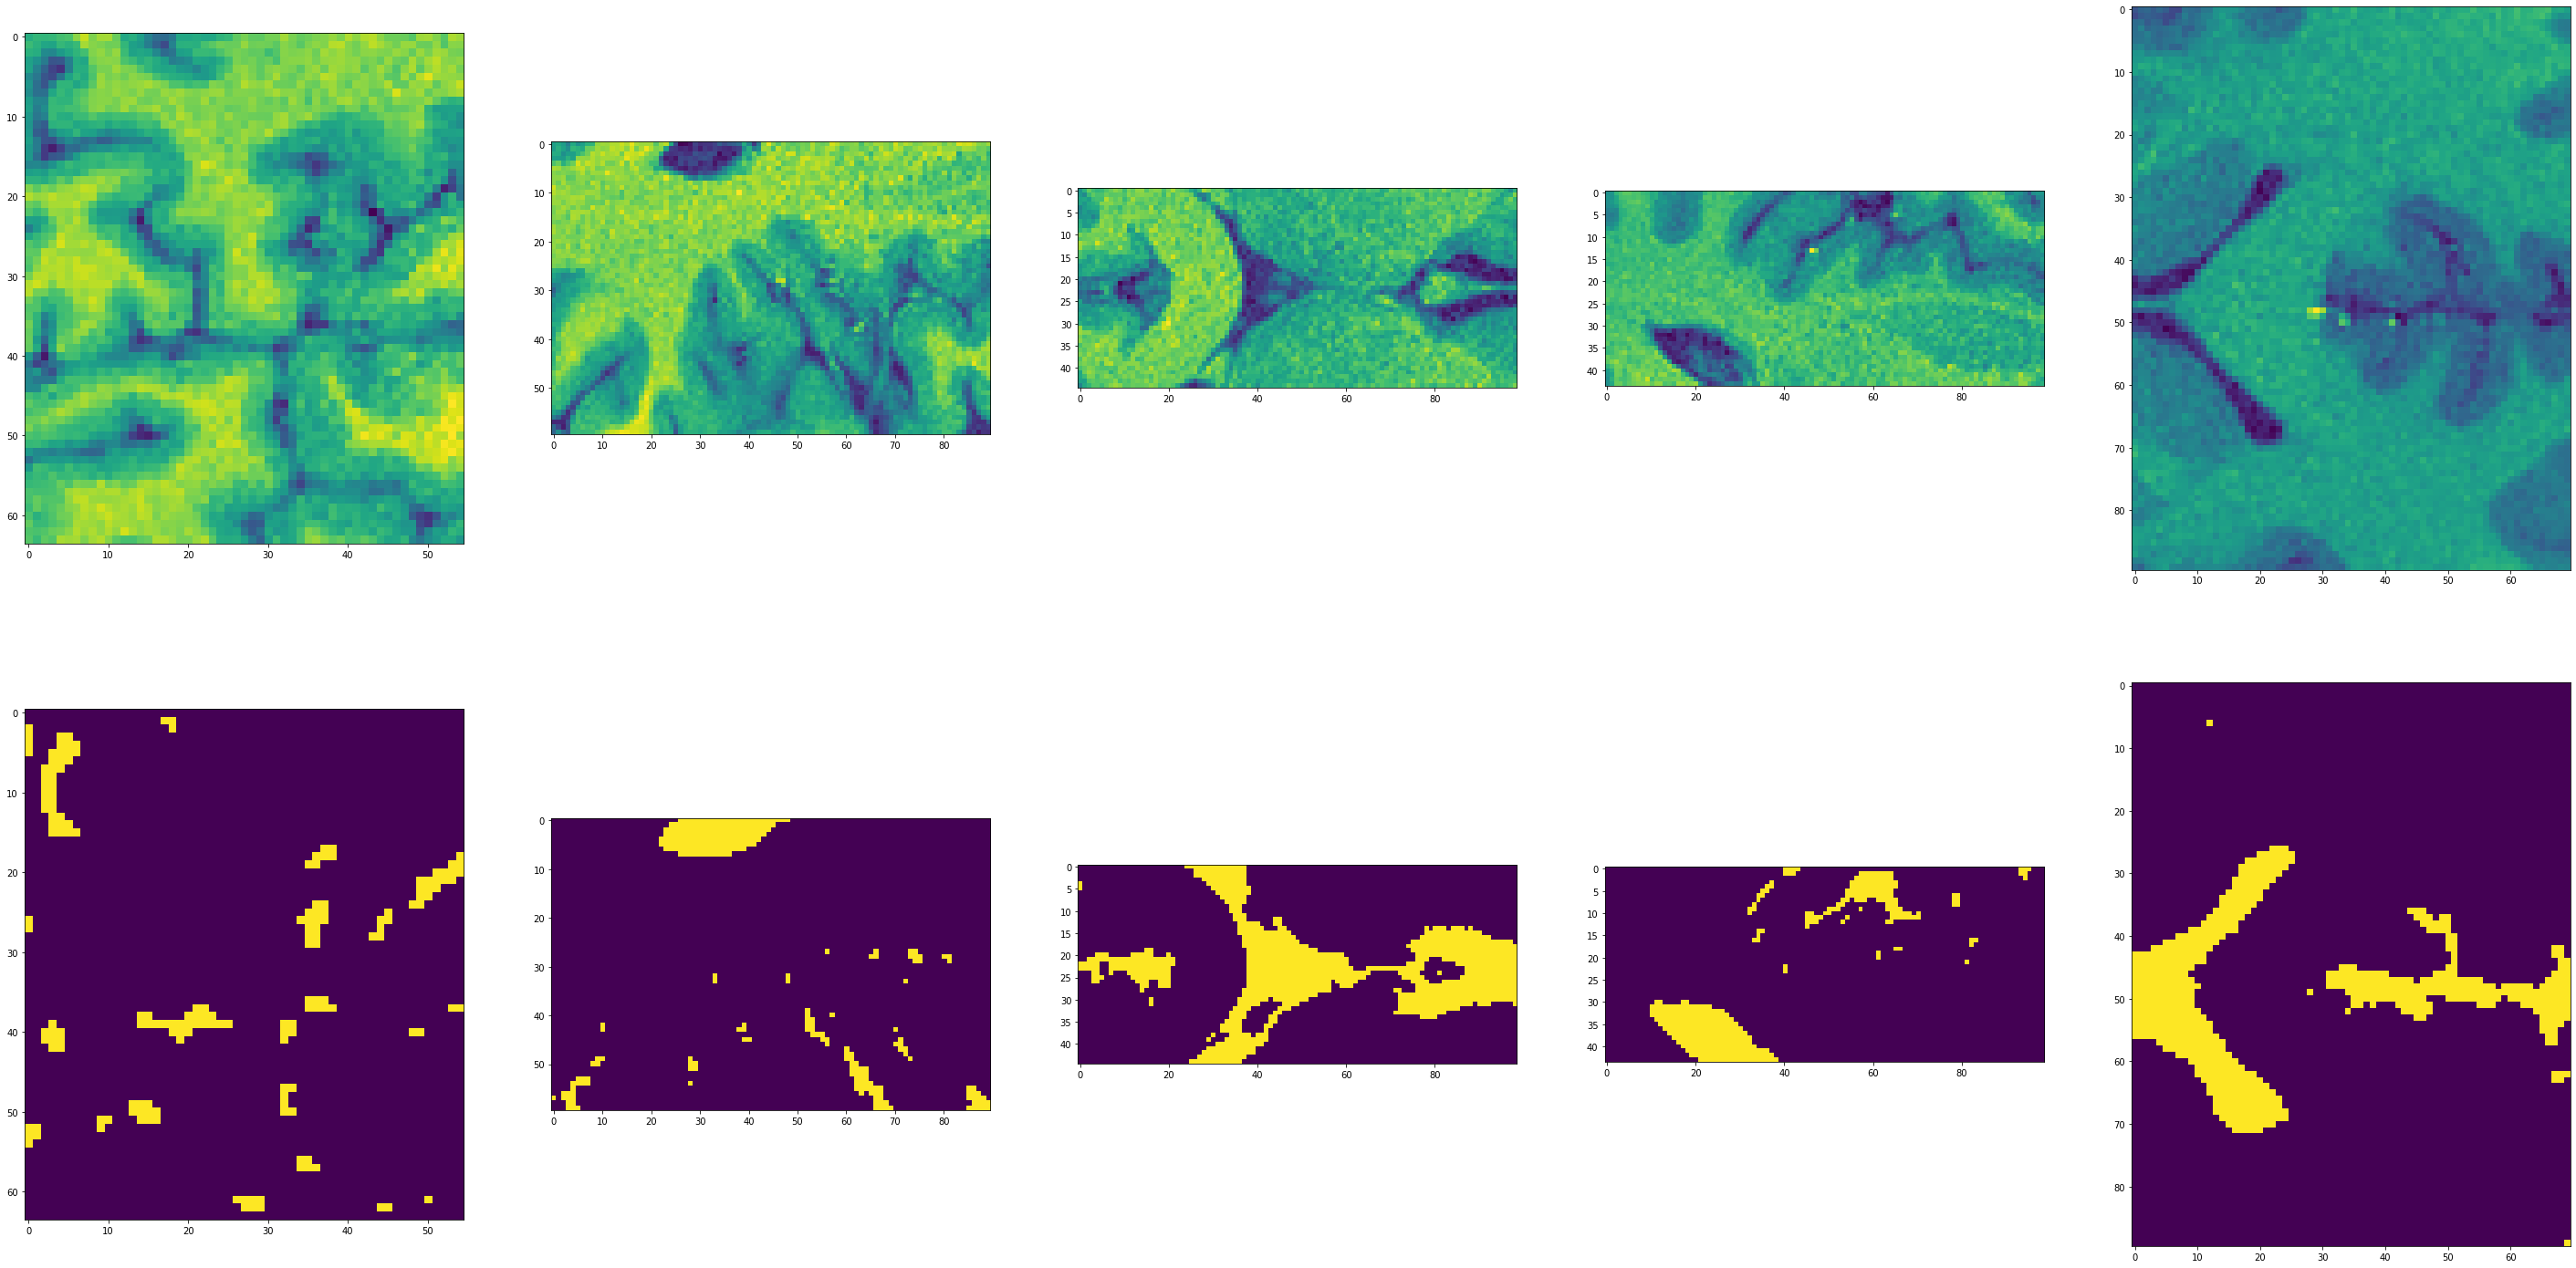

In [14]:
# let's identify what's causing those strange horizontal lines:
map = [[] for x in range(5)]
for i in range(5):
    temp_sos_map = np.array(all_s[i]).flatten()
    map[i] = np.zeros(all_m[i].shape).flatten()
    for j in range(len(temp_sos_map)):
        if(temp_sos_map[j] < 1520):
            map[i][j] = 10000

plt.subplots(2,5, figsize=(50,25))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.imshow(all_m[i])
    plt.subplot(2,5,5+1+i)
    plt.imshow(np.array(map[i]).reshape(all_s[i].shape))

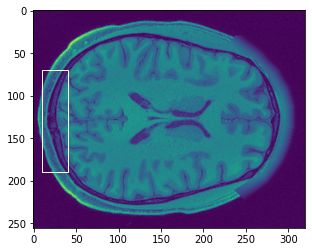

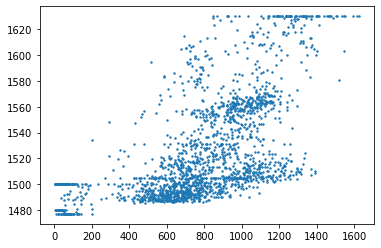

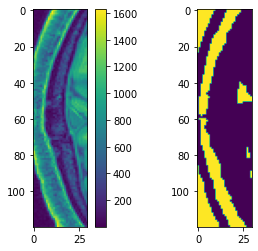

In [20]:
# just checking a different part of the brain also with CSF
where_sections(mri_data[:,:,170],["170,70,190,10,40"])
v_m, v_s = create_sections(mri_data, sos_data, ["170,70,190,10,40"])
f_v_m, f_v_s = filter_one(v_m, v_s, [np.nan,1800])
plt.scatter(f_v_m, f_v_s,s=2)

map = np.zeros(np.array(v_m[0]).shape).flatten()
temp_sos_map = np.array(v_s[0]).flatten()
for j in range(len(temp_sos_map)):
    if(temp_sos_map[j] < 1510):
        map[j] = 10000

plt.subplots(1,2)
plt.subplot(1,2,1)
plt.imshow(v_m[0])
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(np.array(map).reshape(np.array(v_s[0]).shape))

In [15]:
# applying a median filter to get rid of salt and pepper noise
median_m = []
median_s = []
for i in range(len(all_m)):
    median_m.append( ndimage.median_filter(all_m[i], size=4) )
    median_s.append( ndimage.median_filter(all_s[i], size=4) )

fm_m, fm_s = filter_all(median_m, median_s, Ts) # actually filter data

In [16]:
fm_coef, fm_intercept, fm_r2, fm_data = analyse_all(fm_m, fm_s)

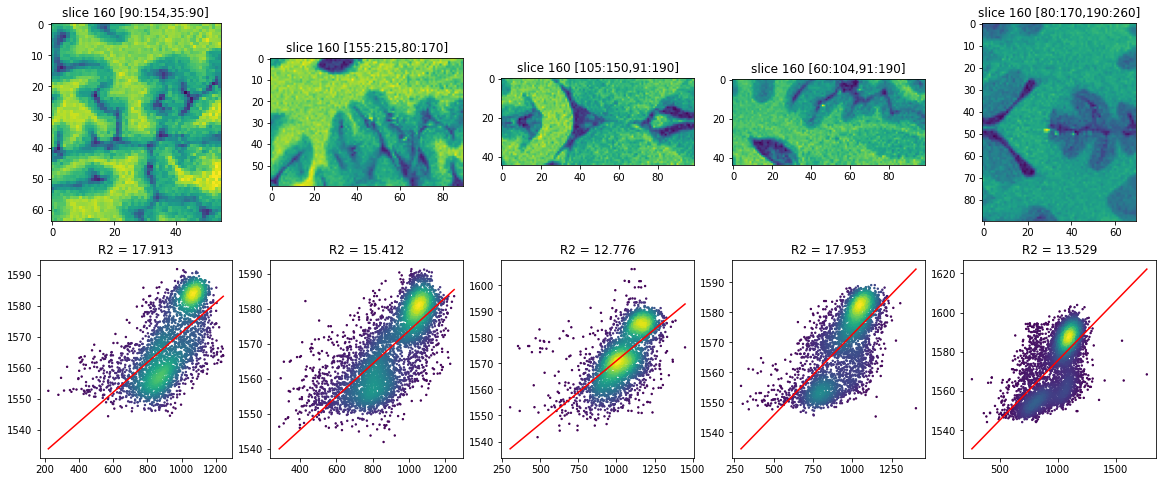

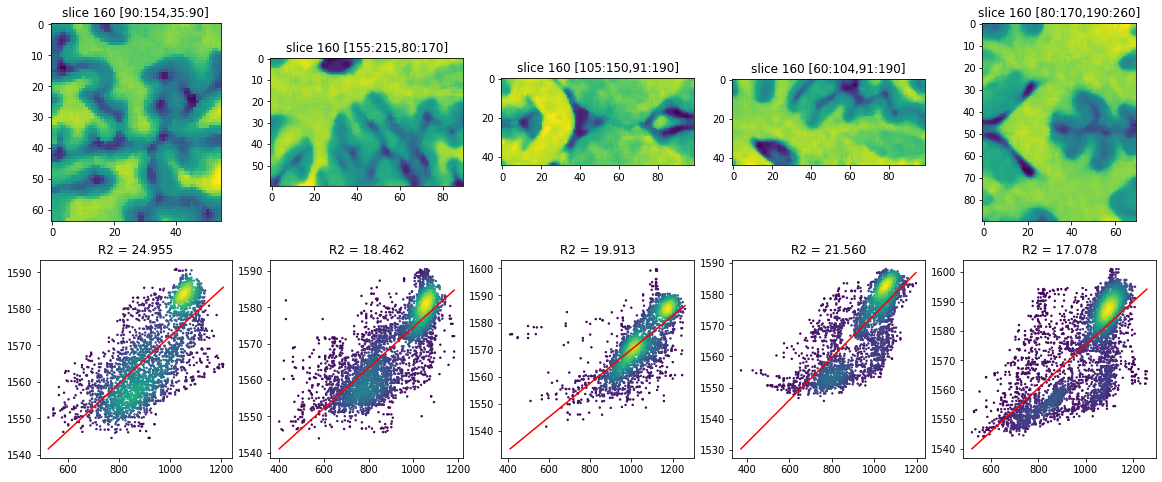

In [17]:
plot_line(all_m, fil_m, fil_s, coef, intercept, r2, labels)
plot_line(median_m, fm_m, fm_s, fm_coef, fm_intercept, fm_r2, labels)

In [ ]:
# now we'll focus on the first and last plots to try and see why one looks more linear than the other

In [38]:
def compare_scatters(m, s, r2):
    """
    Inputs:
      m : list of mri sections
      s : list of sos sections
      r2 : R2 value to be displayed for each

    Outputs:
      nothing

    Function:
      plots the scatter plots side by side
    """
    plt.subplots(1,len(m), figsize=(50,20))
    for i in range(len(m)):
        
        plt.subplot(1,len(m),i+1)

        # this is to make it into a density scatter plot
        xy = np.vstack([m[i], s[i]])
        z = gaussian_kde(xy)(xy)

        plt.scatter(m[i],s[i],c=z,s=30)
        plt.title("R2 = "+str(r2[i]),size=40) 

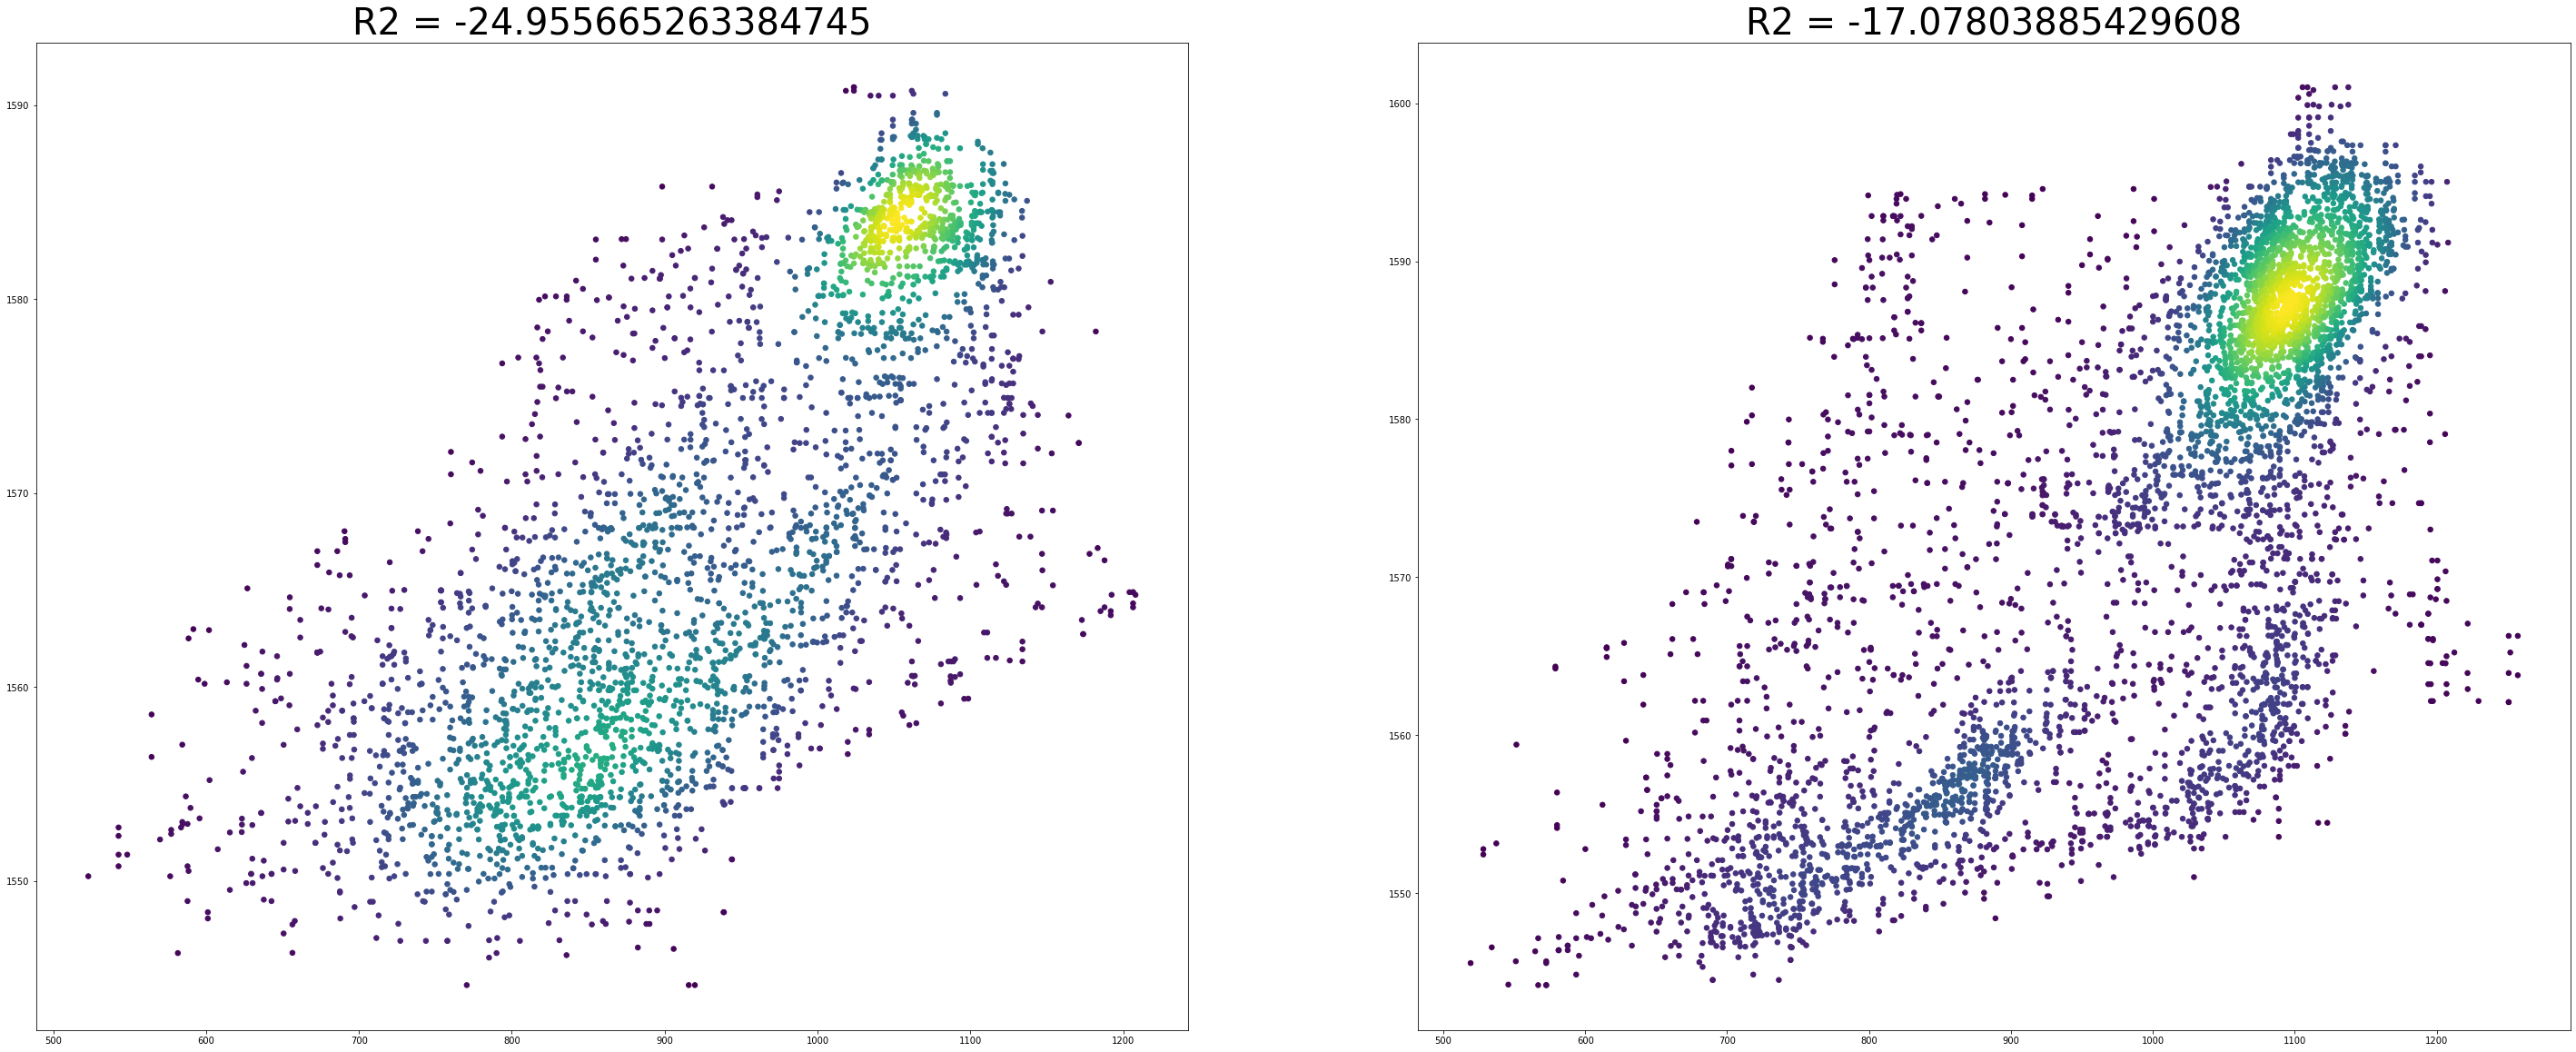

In [39]:
# lets now focus on investigating the leftmost and rightmost graphs of slice 160
good_m = fm_m[0]
good_s = fm_s[0]
bad_m = fm_m[4]
bad_s = fm_s[4]

compare_scatters([good_m, bad_m],[good_s, bad_s], [fm_r2[0], fm_r2[4]])


In [ ]:
# creates a superginormous subplots with batches of 28 new points being added to each subplot
bad_m = np.array(all_m[4]).flatten()
bad_s = np.array(all_s[4]).flatten()
plt.subplots(25,8, figsize=(100,200))
for i in range(1,200):
    plt.subplot(25,8,i)
    c = np.array(['b','r'])
    plt.scatter(bad_m[0:(i-1)*28],bad_s[0:(i-1)*28],c='y')
    plt.scatter(bad_m[(i-1)*28:i*28],bad_s[(i-1)*28:i*28],c='k',s=50)
    plt.title(i*28, size=50)
    

In [ ]:
""" 
NEXT FEW CELLS:
 1 Make a dataframe with the median-filtered MRI, SOS and (x,y) location for each pixel but with the horizontal lines
 2 if a point in this dataframr is NOT within a region around the best-fit
 line or is not in the filtered MRI, delete it 

"""

In [40]:
df = pd.DataFrame()
df['MRI'] = np.array(median_m[4]).flatten()
df['SOS'] = np.array(median_s[4]).flatten()
df['x'] = [j for i in range(90) for j in range(70)]
df['y'] = [i for i in range(90) for j in range(70)]

# filter this database so we dont worry about the horizontal lines
f_df = filter_df(df,Ts[4])
f_df['index'] = [x for x in range(f_df.shape[0])]
f_df

,MRI,SOS,x,y,index
0,635.341919,1551.175632,0,0,0
1,635.341919,1551.175632,1,0,1
2,643.891785,1552.456369,2,0,2
3,672.840393,1554.849426,3,0,3
4,650.339905,1555.586301,4,0,4
...,...,...,...,...,...
6295,883.370178,1556.926285,65,89,5660
6296,882.447571,1555.427411,66,89,5661
6297,878.724304,1554.019121,67,89,5662
6298,878.724304,1551.620972,68,89,5663


593

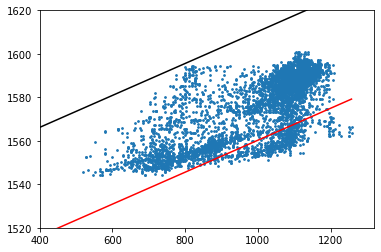

In [30]:
# using parametrs of the filtered data
oor = []

x = np.linspace(0,max(df['MRI']),num=10000)
y1 = fm_coef[4][0][0] * x + fm_intercept[4][0] - 15
y2 = fm_coef[4][0][0] * x + fm_intercept[4][0] + 35

plt.scatter(f_df['MRI'], f_df['SOS'], s=3) 
plt.plot(x, y1, 'r')
plt.plot(x ,y2, 'k')
plt.xlim(400,None)
plt.ylim(1520,1620)

for i in range(len(f_df['MRI'])):
    m = f_df.iloc[i]['MRI']
    s = f_df.iloc[i]['SOS']

    y1 = fm_coef[4][0][0] * m + fm_intercept[4][0] - 15
    y2 = fm_coef[4][0][0] * m + fm_intercept[4][0] + 35

    if (y1 > s) or ( s > y2):
        oor.append([f_df.iloc[i]['x'], f_df.iloc[i]['y']])

len(oor)

In [31]:
df_flag = df.copy()
for i in range(6300):
    if([df_flag['x'][i], df_flag['y'][i]] in oor):
        df_flag['MRI'][i] = 0
        df_flag['SOS'][i] = 0
len(df_flag[df_flag['MRI'] != 0])

/var/folders/rj/5r2r325x6ws_ctzqd729mdf00000gn/T/ipykernel_26918/3457352631.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flag['MRI'][i] = 0
/var/folders/rj/5r2r325x6ws_ctzqd729mdf00000gn/T/ipykernel_26918/3457352631.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_flag['SOS'][i] = 0


5707

(1520.0, 1620.0)

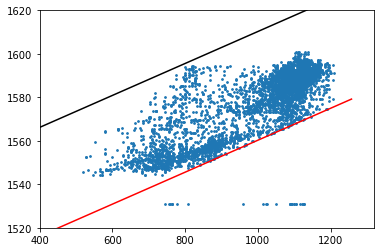

In [29]:
plt.scatter(df_flag['MRI'],df_flag['SOS'],s=3)
plt.plot(x, fm_coef[4][0][0] * x + fm_intercept[4][0] - 15, 'r')
plt.plot(x ,fm_coef[4][0][0] * x + fm_intercept[4][0] + 35, 'k')
plt.xlim(400,None)
plt.ylim(1520,1620)

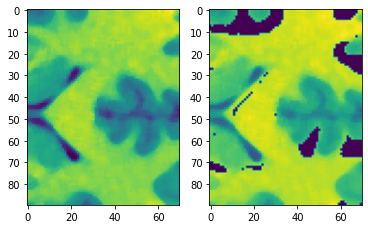

In [32]:
plt.subplots(1,2)
plt.subplot(1,2,1)
plt.imshow(median_m[4])
plt.subplot(1,2,2)
plt.imshow(np.array(df_flag['MRI']).reshape(90,70))

In [33]:
# doing the same for the 'good' one to compare the results:
dfg = pd.DataFrame()
dfg['MRI'] = np.array(median_m[0]).flatten()
dfg['SOS'] = np.array(median_s[0]).flatten()
dfg['x'] = [j for i in range(all_m[0].shape[0]) for j in range(all_m[0].shape[1])]
dfg['y'] = [i for i in range(all_m[0].shape[0]) for j in range(all_m[0].shape[1])]
f_dfg = filter_df(dfg,Ts[0])
f_dfg['index'] = [x for x in range(f_dfg.shape[0])]

# using parametrs of the filtered data
oor = []
for i in range(len(f_dfg['MRI'])):
    m = f_dfg.iloc[i]['MRI']
    s = f_dfg.iloc[i]['SOS']

    y1 = fm_coef[0][0][0] * m + fm_intercept[0][0] - 15
    y2 = fm_coef[0][0][0] * m + fm_intercept[0][0] + 35
    if (y1 > s) or ( s > y2):
        oor.append([f_dfg.iloc[i]['x'], f_dfg.iloc[i]['y']])
print(len(oor))
dfg_flag = dfg.copy()
for i in range(dfg['MRI'].shape[0]):
    if([dfg_flag['x'][i], dfg_flag['y'][i]] in oor):
        dfg_flag['MRI'][i] = 0
        dfg_flag['SOS'][i] = 0

95


/var/folders/rj/5r2r325x6ws_ctzqd729mdf00000gn/T/ipykernel_26918/302268651.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfg_flag['MRI'][i] = 0
/var/folders/rj/5r2r325x6ws_ctzqd729mdf00000gn/T/ipykernel_26918/302268651.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfg_flag['SOS'][i] = 0


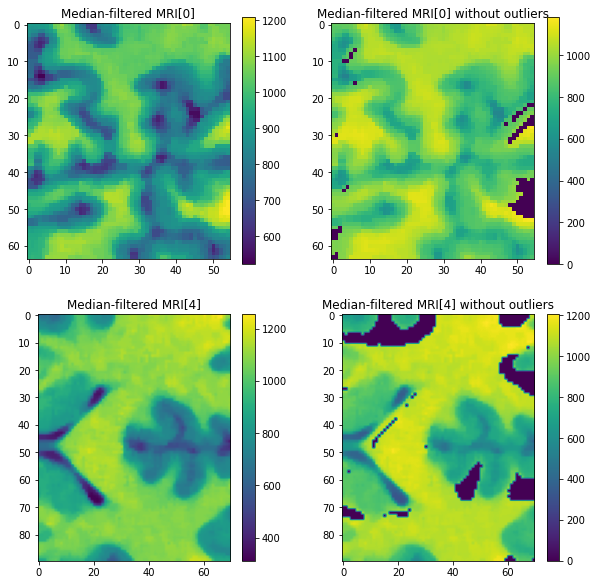

In [34]:
plt.subplots(2,2, figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(median_m[0])
plt.colorbar()
plt.title("Median-filtered MRI[0]")
plt.subplot(2,2,2)
plt.title("Median-filtered MRI[0] without outliers")
plt.imshow(np.array(dfg_flag['MRI']).reshape(all_m[0].shape))
plt.colorbar()
plt.subplot(2,2,3)
plt.title("Median-filtered MRI[4]")
plt.imshow(median_m[4])
plt.colorbar()
plt.subplot(2,2,4)
plt.title("Median-filtered MRI[4] without outliers")
plt.imshow(np.array(df_flag['MRI']).reshape(all_m[4].shape))
plt.colorbar()

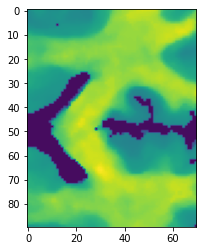

In [37]:
# therefore, linear regression fails to give correct values even when looking exclusively at GM and WM, proving that it's not going to be a suitable model  